# Spam Ham Classification

In [1]:
#Importing essential libraries


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [2]:
#Load dataset


# Encoding the data using only the first columns: the other seems to be an issue of the data (empty)

#df = pd.read_csv('/home/mona/Desktop/python_notebooks/supervised_machine_learning/data_files/spam.csv', sep ='\t' )
df = pd.read_csv('https://raw.githubusercontent.com/mona-patra/FDP-5days/main/Day%203/spam.csv', sep ='\t' )
#df = pd.read_csv('/home/mona/ml_tutorial/data_files/spam.csv', sep=',', encoding='latin-1', usecols=lambda col: col not in ["Unnamed: 2","Unnamed: 3","Unnamed: 4"])

In [3]:
df.head()

,Type,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.describe()

,Type,Message
count,656,656
unique,2,647
top,ham,"Sorry, I'll call later"
freq,577,5


In [5]:
df.groupby('Type').describe()

Message                                                               
       count unique                                                top freq
Type                                                                       
ham      577    568                             Sorry, I'll call later    5
spam      79     79  You have won a Nokia 7250i. This is what you g...    1

We make a new column to detect how long the text messages are

In [9]:
df['length']=df['Message'].apply(len)
df.head()

,Type,Message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


# Let us first start with data visualization

In [7]:
import seaborn as sns
%matplotlib inline

<AxesSubplot:ylabel='Frequency'>

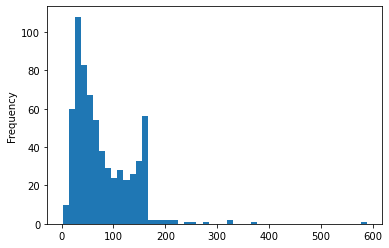

In [8]:
df['length'].plot(bins=50,kind='hist')

In [9]:
df.length.describe()

count    656.000000
mean      78.175305
std       55.969796
min        2.000000
25%       36.000000
50%       60.500000
75%      114.000000
max      588.000000
Name: length, dtype: float64

The maximum length of the message is 588 characters. Let us see what is in the message

In [10]:
df[df['length']==588]['Message'].iloc[0]

"Sad story of a Man - Last week was my b'day. My Wife did'nt wish me. My Parents forgot n so did my Kids . I went to work. Even my Colleagues did not wish. As I entered my cabin my PA said, '' Happy B'day Boss !!''. I felt special. She askd me 4 lunch. After lunch she invited me to her apartment. We went there. She said,'' do u mind if I go into the bedroom for a minute ? '' ''OK'', I sed in a sexy mood. She came out 5 minuts latr wid a cake...n My Wife, My Parents, My Kidz, My Friends n My Colleagues. All screaming.. SURPRISE !! and I was waiting on the sofa.. ... ..... ' NAKED...!"

<AxesSubplot:ylabel='Type'>

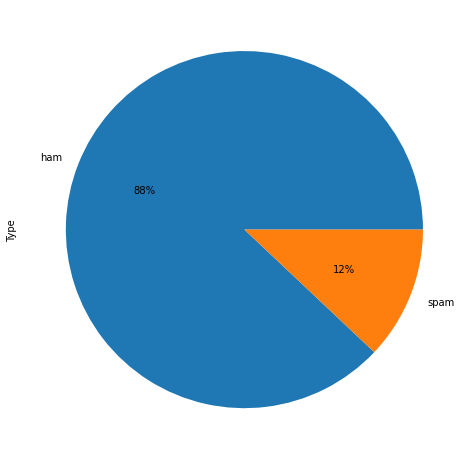

In [11]:
plt.rcParams["figure.figsize"] = [8,10] 
df.Type.value_counts().plot(kind='pie', autopct='%1.0f%%')

In [22]:
##### creates a list which contains number of words in ham messages
##### and their count of occurrence in the dataset

df_ham = df[df['Type'] == "ham"]
df_ham_count = df_ham['Message'].str.split().str.len()
df_ham_count.index = df_ham_count.index.astype(str) + ' words:'
df_ham_count.sort_index(inplace=True)


##### Similarly create a list which contains number of words in spam 
##### messages and their count of occurrence in the dataset

df_spam = df[df['Type'] == "spam"]
df_spam_count = df_spam['Message'].str.split().str.len()
df_spam_count.index = df_spam_count.index.astype(str) + ' words:'
df_spam_count.sort_index(inplace=True)


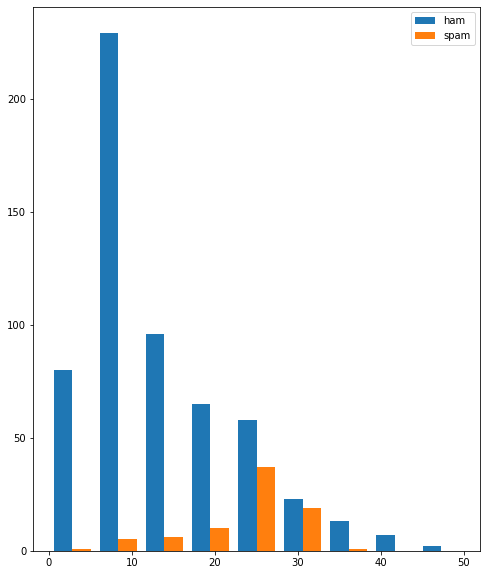

In [13]:
###  plots histogram using the spam and ham message list that was created

bins = np.linspace(0, 50, 10)

plt.hist([df_ham_count, df_spam_count], bins, label=['ham', 'spam'])
plt.legend(loc='upper right')
plt.show()

We now return to text Pre-processing, where we first clean the data. Afterwards we use the bag-of-words approach, where each word in a text will be represented by one number. The we compute the tf-idf score

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mona/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
stops = set(stopwords.words('english'))
print(stops)

{'while', "didn't", 'didn', 'more', 'why', 'until', 'such', 'her', 'have', 'o', 'needn', 'an', 'himself', 'that', 'from', 'at', 'if', 'wasn', 'any', 'nor', 'for', 't', 'll', "mustn't", 'they', 'were', 'only', "won't", 'herself', 're', "wouldn't", 'just', 'doesn', "should've", 'don', 'and', 'shan', 'below', 'was', "haven't", 'off', 'yourselves', 'in', "aren't", 'their', 'between', 'too', 'not', 'hadn', 'doing', "hasn't", 'your', 'had', 'are', 'same', 'haven', 'you', 'out', 'through', 'mightn', 'this', 'he', 's', 'own', 'ourselves', "couldn't", 'whom', 'it', 'some', 'by', 'who', "don't", 'having', "doesn't", 'but', 'so', 'most', "weren't", 'me', 'of', 'again', 'won', 'what', 'into', 'is', 'theirs', 'his', 'about', 'being', 'its', 'do', 'myself', 'hasn', 'our', 'after', 'under', 'been', 'then', 'isn', "it's", 'did', 'over', 'than', 'we', 'or', "hadn't", 'ours', 'mustn', "you're", 'itself', "you'd", 'here', 'with', 'aren', 'does', 'which', 'because', 'she', 'where', 'will', 'my', 'no', 'th

In [8]:
# remove stopwords
from nltk.corpus import stopwords 
import string

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [15]:
def text_preprocess(sen): 

    sen = re.sub('[^a-zA-Z]', ' ', sen)  # Remove punctuations and numbers 

    sen = re.sub(r"\s+[a-zA-Z]\s+", ' ', sen) # Single character removal 

    sen = re.sub(r'\s+', ' ', sen) #remove extra spaces from the data
    
    sen = remove_stopwords(sen) # remove stopwords
    return sen

In [16]:
X = df["Message"].str.lower()  
 
y = df["Type"]

X_messages = [] 
messages = list(X) 


for mes in messages: 
    X_messages.append(text_preprocess(mes))

In [44]:
print(X_messages)

['go jurong point crazy available bugis great world la buffet cine got amore wat', 'ok lar joking wif oni', 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply', 'u dun say early hor c already say', 'nah think goes usf lives around though', 'freemsg hey darling week word back like fun still tb ok xxx std chgs send rcv', 'even brother like speak treat like aids patent', 'per request melle melle oru minnaminunginte nurungu vettam set callertune callers press copy friends callertune', 'winner valued network customer selected receivea prize reward claim call claim code kl valid hours', 'mobile months r entitled update latest colour mobiles camera free call mobile update co free', 'gonna home soon want talk stuff anymore tonight cried enough today', 'six chances win cash pounds txt csh send cost day days tsandcs apply reply hl info', 'urgent week free membership prize jackpot txt word claim c www dbuk net lccltd pobox ldnw rw', 'finally mat

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer 

tfidf_vec = TfidfVectorizer (max_features=2500, min_df=0.01, max_df=0.8) 
X= tfidf_vec.fit_transform(X_messages).toarray()

Assume general form: (A,B) C

A: Document index B: Specific word-vector index C: TFIDF score for word B in document A

This is a sparse matrix. It indicates the tfidf score for all non-zero values in the word vector for each document.

In [27]:
print(tfidf_vec.fit_transform(X_messages))

  (0, 124)	0.5212767198691949
  (0, 38)	0.46946527042117314
  (0, 39)	0.5602852739662546
  (0, 35)	0.44040135441134426
  (1, 75)	1.0
  (2, 115)	0.5072774983965226
  (2, 104)	0.4780212805995937
  (2, 129)	0.5691785344850576
  (2, 31)	0.4361203856688343
  (3, 1)	0.4472135954999579
  (3, 87)	0.8944271909999159
  (4, 109)	1.0
  (5, 89)	0.3685934527912445
  (5, 97)	0.38857403137020013
  (5, 53)	0.3585197216594345
  (5, 8)	0.372233485588321
  (5, 126)	0.4087918579827129
  (5, 43)	0.41469267072283184
  (5, 75)	0.32706900768485675
  (6, 27)	0.5006425073585473
  (6, 53)	0.8656541340661101
  (7, 32)	1.0
  (8, 11)	0.27045445440831967
  (8, 13)	0.8610943679252341
  (8, 83)	0.43054718396261704
  :	:
  (647, 134)	0.7335933839680782
  (648, 56)	0.6566358133579728
  (648, 84)	0.39580096982090807
  (648, 40)	0.6420054523947145
  (649, 51)	0.6545823709037766
  (649, 96)	0.6206540021382274
  (649, 11)	0.43163703424496824
  (650, 92)	0.693088678223984
  (650, 56)	0.5154293128203808
  (650, 40)	0.503945143

In [31]:
print('Shape of Sparse Matrix: ',X.shape)

Shape of Sparse Matrix:  (656, 135)


In [19]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
#Create Model for Logistic Regression

model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [38]:
# Create Model for Naive Bayes

from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(X_train,y_train)

In [39]:
#Making predictions¶

predictionLR = dict()
predictionLR["Logistic"] = model.predict(X_test)

predictionNB = dict()
predictionNB["Naive Bayes"] = spam_detect_model.predict(X_test)


In [36]:
# Evaluate Model¶

accuracy_score(y_test,predictionLR["Logistic"])

0.8963414634146342

In [40]:
accuracy_score(y_test,predictionNB["Naive Bayes"])

0.9390243902439024

In [23]:
print(classification_report(y_test,predictionLR["Logistic"]))

              precision    recall  f1-score   support

         ham       0.90      0.99      0.94       143
        spam       0.75      0.29      0.41        21

    accuracy                           0.90       164
   macro avg       0.83      0.64      0.68       164
weighted avg       0.88      0.90      0.88       164



In [41]:
print(classification_report(y_test,predictionNB["Naive Bayes"]))

              precision    recall  f1-score   support

         ham       0.93      1.00      0.97       143
        spam       1.00      0.52      0.69        21

    accuracy                           0.94       164
   macro avg       0.97      0.76      0.83       164
weighted avg       0.94      0.94      0.93       164



In [42]:
print(confusion_matrix(y_test,predictionLR["Logistic"]))

[[141   2]
 [ 15   6]]


In [43]:
print(confusion_matrix(y_test,predictionNB["Naive Bayes"]))

[[143   0]
 [ 10  11]]
